In [1]:
import socket
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl
import struct
import errno

In [2]:
# Create an TCP socket
def SocketConnect():
    try:
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    except socket.error:
        print ('Failed to create socket.')
    try:
        s.connect((remote_ip , port))
        s.setblocking(False)
    except socket.error:
        print ('failed to connect to ip ' + remote_ip)
    return s

In [3]:
# Close the socket
def SocketClose(Sock):
    Sock.close()
    time.sleep(5)

In [4]:
# Send message to the scope
def SocketQuery(sock, cmd, size=8000):
    try :
        sock.sendall(cmd + b'\n')
    except socket.error as error:
        #Send failed
        print ('Send failed')
        print(os.strerror(error.errno))

    data = None    
    while True:
        try:
            time.sleep(0.01)
            if data == None:
                data = sock.recv(size)
            else:
                data += sock.recv(size)
        except BlockingIOError:
            if data == None:
                pass
            else:
                return data

### Timebase lookup

The wave descriptor returns an index into a timebase lookup table. The following table is the translation from index to timebase.

In [5]:
tbase_lookup = np.array([200e-12,
                  500e-12,
                  1e-9,
                  2e-9,
                  5e-9,
                  10e-9,
                  20e-9,
                  50e-9,
                  100e-9,
                  200e-9,
                  500e-9,
                  1e-6,
                  2e-6,
                  5e-6,
                  10e-6,
                  20e-6,
                  50e-6,
                  100e-6,
                  200e-6,
                  500e-6,
                  1e-3,
                  2e-3,
                  5e-3,
                  10e-3,
                  20e-3,
                  50e-3,
                  100e-3,
                  200e-3,
                  500e-3,
                  1,
                  2,
                  5,
                  10,
                  20,
                  50,
                  100])

In [6]:
xticks = [
    ['0','','','','','1ns','','','','','2ns','','','',''],
    ['0','','1ns','','2ns','','3ns','','4ns','','5ns','','6ns','','7ns'],

    ['0','','','','','5ns','','','','','10ns','','','',''],
    ['0','','','','','10ns','','','','','20ns','','','',''],
    ['0','','10ns','','20ns','','30ns','','40ns','','50ns','','60ns','','70ns'],

    ['0','','','','','50ns','','','','','100ns','','','',''],
    ['0','','','','','100ns','','','','','200ns','','','',''],
    ['0','','100ns','','200ns','','300ns','','400ns','','500ns','','600ns','','700ns'],

    ['0','','','','','500ns','','','','','1ms','','','',''],
    ['0','','','','','1us','','','','','2us','','','',''],
    ['0','','1us','','2us','','3us','','4us','','5us','','6us','','7us'],

    ['0','','','','','5us','','','','','10us','','','',''],
    ['0','','','','','10us','','','','','20us','','','',''],
    ['0','','10us','','20us','','30us','','40us','','50us','','60us','','70us'],

    ['0','','','','','50us','','','','','100us','','','',''],
    ['0','','','','','100us','','','','','200us','','','',''],
    ['0','','100us','','200us','','300us','','400us','','500us','','600us','','700us'],

    ['0','','','','','500us','','','','','1ms','','','',''],
    ['0','','','','','1ms','','','','','2ms','','','',''],
    ['0','','1ms','','2ms','','3ms','','4ms','','5ms','','6ms','','7ms'],

    ['0','','','','','5ms','','','','','10ms','','','',''],
    ['0','','','','','10ms','','','','','20ms','','','',''],
    ['0','','10ms','','20ms','','30ms','','40ms','','50ms','','60ms','','70ms'],

    ['0','','','','','50ms','','','','','100ms','','','',''],
    ['0','','','','','100ms','','','','','200ms','','','',''],
    ['0','','100ms','','200ms','','300ms','','400ms','','500ms','','600ms','','700ms'],

    ['0','','','','','500ms','','','','','1s','','','',''],
    ['0','','','','','1s','','','','','2s','','','',''],
    ['0','','1s','','2s','','3s','','4s','','5s','','6s','','7s'],

    ['0','','','','','5s','','','','','10s','','','',''],
    ['0','','','','','10s','','','','','20s','','','',''],
    ['0','','10s','','20s','','30s','','40s','','50s','','60s','','70s'],

    ['0','','','','','50s','','','','','100s','','','',''],
    ['0','','','','','100s','','','','','200s','','','',''],
    ['0','','100s','','200s','','300s','','400s','','500s','','600s','','700s']
]

In [7]:
remote_ip = "169.254.1.177"
port = 5025

In [8]:
# This translates the display value (-127..128) to a voltage.
def toV(x,vgain,voffset,probe_att):
    return (x / 128 * vgain * 5 - voffset) * probe_att

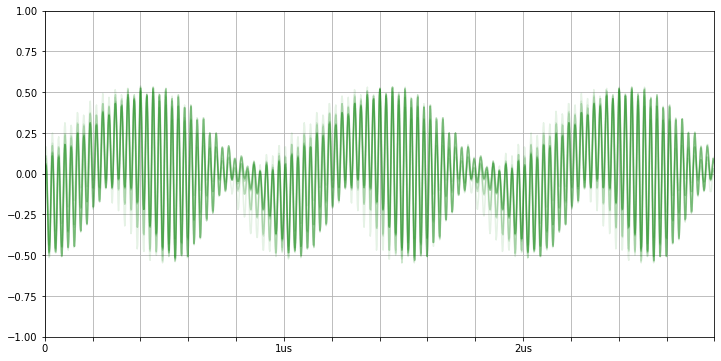

In [9]:
try:
    s = SocketConnect()

    plt.figure(figsize=(12,6))
    plt.margins(0)
    lines = []

    while True:
        try:
            # Get the waveform data
            response = SocketQuery(s, b'C1:WF? DAT2', size=10000_000)

            # find the b'#9' marker
            _nine = response.index(b'#9')
            # the wave data starts at 11 bytes after b'#9' and ends with b'\n\n'
            wave = response[_nine+11:-2]
            w = np.frombuffer(wave,dtype=np.int8)

            # Get the waveform descriptor
            response = SocketQuery(s, b'C2:WF? DESC', size=100_000)
            desc = response[11+11:]
            vgain, = struct.unpack('f', desc[156:160])
            voffset, = struct.unpack('f', desc[160:164])
            probe_att, = struct.unpack('f', desc[328:332])
            _tb = struct.unpack('h', desc[324:326])[0]
            timebase = tbase_lookup[_tb]

            v = toV(w,vgain,voffset,probe_att)

            # remove oldest of the previous lines (if any)
            if len(lines)>10:
                line = lines[0]
                lines.remove(line)
                line.remove()

            # set the x limits and ticks
            plt.xlim(0,len(v)-1)    # this is needed for if the number of points changes
            ticks = np.linspace(0,len(w)-1,num=15,endpoint=True)
            plt.xticks(ticks=ticks,labels=xticks[_tb])
            plt.grid(True)

            # create plot, and remember the lines to remove them later
            line, = plt.plot(v,'green',alpha=0.1)
            lines.append(line)

            # set the y limits and ticks
            _min = toV(-128,vgain,voffset,probe_att)
            _max = toV(128,vgain,voffset,probe_att)
            plt.ylim(_min,_max)

            # make plot visible
            display.clear_output(wait=True)
            display.display(pl.gcf()) 
        except KeyboardInterrupt:
            break
finally:
    SocketClose(s)

# Issues

## Issue 1
There is still an issue with triggering at small timebases. A 10MHz sine, rising edge triggered at 0 volt, timebase 10ns, memdepth 7K, the notebooks display does not cross 0 volts at 70ns but always later than 70ns.

<img src='Notebook.jpg'>

On the oscilloscope it always crosses 0 volts at exactly 70ns (middle of the screen). Even at smaller timebases it crosses 0 volts at the middle of screen.

<img src='SCDP.bmp'>

### Probable cause
The lower samplerate results in a smaller resolution, which together with higher signal frequency more quickly shows the issue.

The oscilloscope probably does some interpolation at which time the zero-crossing actually appears, and adjusts the wave accordingly to it before displaying it. In the waveform descriptor there are extra fields which possibly could help do the same in the notebook. These fields are (possibly)

<180>          HORIZ_OFFSET: double     ; trigger offset for the first sweep of
                                         ; the trigger, seconds between the
                                         ; trigger and the first data point
;
<188>          PIXEL_OFFSET: double     ; needed to know how to display the
                                         ; waveform
;
<292>          HORIZ_UNCERTAINTY: float ; uncertainty from one acquisition to the
                                        ; next, of the horizontal offset in seconds
;
<296>          TRIGGER_TIME: time_stamp ; time of the trigger
;

## Issue 2

Values as returned in the wave descriptor are taken at the time the waveform was sampled. Putting the oscilloscope in stop mode and changing settings such as timebase/vertical gain/ vertical offset/... results in discrepancies between what is displayed on the screen of the scope and what is displayed in the notebook. Actual values for the scope settings can be obtained by sending queries as C1:OFST? to get the actual offset. This results in more queries being sent (gain, vertical offset, timebase, probe attenuation and possibly more) which will make the update rate even slower.

## Issue 3

Update rate in the notebook is slow. This is caused by communication with the oscilloscope as CPU of the computer usage is at most 50%. Communication with the scope is over TCP. The SDS1202X-E scope does not support the faster UDP protocol (see https://siglentna.com/operating-tip/do-your-instruments-support-udp-communications-over-lan/).

